# Libraries

In [87]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Loading the Files

Download the csv files into the `data/` directory.

In [88]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Adding Features

In [51]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Add the vader sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    df['vader component'] = df['Text'].fillna('').apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['vader pos/neu/neg'] = df['vader component'].apply(lambda x: 1 if x >= 0.05 else (0 if x > -0.05 else -1))

    df['length'] = df['Text'].fillna('').apply(lambda x: len(x))                # the length of the review
    df['month'] = df['Time'].apply(lambda x: x // 2629743)                      # the month of the review, counted as months since 1970. So basically, this is a recency score

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    print("X_train.csv shape is ", train.shape)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

X_train.csv shape is  (1697533, 14)


# Sample + Split into training and testing set

In [84]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

KeyError: "['Score'] not found in axis"

# Feature Selection

In [79]:
features = ['Helpfulness', 'vader pos/neu/neg', 'length', 'month']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [86]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

ValueError: could not convert string to float: 'positive'

# Model Evaluation

Accuracy on testing set =  0.40876187603679687


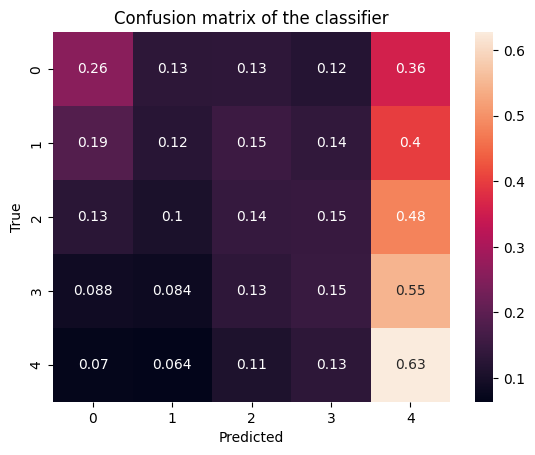

In [77]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [78]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- vader component
